In [14]:
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
# Define constants
COUNT_THRESHOLD = 5  # Count threshold for labeling a node as a leaf
MAX_DEPTH = 3  # Maximum depth for the decision tree

In [16]:
# Function 1: Calculate Gini Impurity
def calculate_gini(data):
    """
    Calculates the Gini impurity for a given dataset.

    Gini Impurity is a metric used to measure how "pure" a dataset is.
    - A pure dataset (all labels are the same) has Gini = 0.
    - A completely heterogeneous dataset has Gini close to 1.

    Formula:
        Gini = 1 - Σ(p_i^2)  for all labels i
        where p_i is the proportion of rows with label i.

    Args:
        data: A list of rows. Each row is a list, and the last element is the target label.

    Returns:
        A float representing the Gini impurity.
    """
    # Hint: Count the occurrences of each label in the dataset.
    # Hint: Compute the probability of each label and use the formula for Gini impurity.
    
    # TODO: Implement the Gini impurity formula
    labels = [row[-1] for row in data]
    total = len(labels)
    label_counts = {label: labels.count(label) for label in set(labels)}
    gini = 1 - sum((count / total) ** 2 for count in label_counts.values())
    return gini

In [17]:
# Function 2: Split dataset by an attribute
def split_data(data, attribute_index, value):
    """
    Splits the dataset into a subset based on the value of a specified attribute.

    Args:
        data: A list of rows. Each row is a list of attribute values.
        attribute_index: The index of the attribute to split on.
        value: The value of the attribute to match.

    Returns:
        A subset of the dataset where rows have the attribute at attribute_index equal to value.
    """
    # Hint: Use a list comprehension to filter rows based on the attribute value.
    # Hint: Remember to only include rows where data[attribute_index] == value.
    
    # TODO: Filter the rows based on the attribute value
    return [row for row in data if row[attribute_index] == value]

In [18]:
# Function 3: Calculate Gini Gain
def gini_gain(data, attribute_index):
    """
    Calculates the Gini gain for a specific attribute.

    Gini Gain measures how much Gini impurity decreases when splitting the dataset
    on a specific attribute. The higher the gain, the better the attribute is for splitting.

    Formula:
        Gini Gain = Gini(parent) - Σ(weighted Gini(child subsets))

    Args:
        data: A list of rows. Each row is a list, and the last element is the target label.
        attribute_index: The index of the attribute to evaluate.

    Returns:
        A float representing the Gini gain for the attribute.
    """
    # Hint: Use calculate_gini() to compute the Gini impurity of the parent dataset.
    # Hint: Use split_data() to create subsets for each unique value of the attribute.
    # Hint: Compute the weighted Gini impurity for the subsets.
    
    # TODO: Implement the Gini gain formula
    parent_gini = calculate_gini(data)
    total = len(data)
    unique_values = set(row[attribute_index] for row in data)
    weighted_gini = 0
    for value in unique_values:
        subset = split_data(data, attribute_index, value)
        weighted_gini += (len(subset) / total) * calculate_gini(subset)
    return parent_gini - weighted_gini

In [19]:
# Function 4: Build the Decision Tree
def build_tree(data, attributes, depth=0):
    """
    Recursively builds a decision tree using Gini impurity to find the best splits.

    Stopping conditions:
    1. No attributes left to split on.
    2. Depth exceeds MAX_DEPTH.
    3. Number of elements in a leaf is less than COUNT_THRESHOLD.

    Args:
        data: A list of rows. Each row is a list, and the last element is the target label.
        attributes: A list of indices representing the available attributes for splitting.

    Returns:
        A dictionary representing the decision tree.
    """
    # Hint: Use calculate_gini() to check if the dataset is pure.
    # Hint: If no attributes remain, return the majority label in the dataset.
    # Hint: Use gini_gain() to find the best attribute for splitting.
    
    # This is what a decsision tree should look like
    # {2: {'Single': {3: {'Low': 'Yes', 'Medium': 'No', 'High': {1: {'Low': 'Yes', 'High': 'No'}}}}, 'Married': 'Yes', 'Divorced': 'No'}}
    
    # TODO: Handle stopping conditions
    labels = [row[-1] for row in data]
    if len(set(labels)) == 1:
        return labels[0]
    if not attributes or len(data) <= COUNT_THRESHOLD or depth >= MAX_DEPTH:
        return max(set(labels), key=labels.count)
    best_attr = max(attributes, key=lambda attr: gini_gain(data, attr))
    tree = {best_attr: {}}
    unique_values = set(row[best_attr] for row in data)
    for value in unique_values:
        subset = split_data(data, best_attr, value)
        subtree = build_tree(subset, [attr for attr in attributes if attr != best_attr], depth + 1)
        tree[best_attr][value] = subtree
    return tree


In [26]:
# Function 5: Predict a Single Instance
def predict(tree, instance):
    """
    Predicts the label for a single instance using the decision tree.

    Args:
        tree: The decision tree (dictionary).
        instance: A dictionary where keys are attribute indices and values are the instance's attribute values.

    Returns:
        The predicted label for the instance.
    """
    # Hint: Traverse the tree based on the instance's attribute values.
    # Hint: If the current node is a dictionary, look up the next branch using the instance value.
    # Hint: If the current node is not a dictionary, return it as the predicted label.
    
    # TODO: Implement tree traversal logic for prediction
    if not isinstance(tree, dict):
        return tree
    root = list(tree.keys())[0]
    if root not in instance:
        return None  # Handle missing attribute by returning None
    value = instance[root]
    subtree = tree[root].get(value, None)
    if subtree is None:
        return None  # Handle missing branch
    return predict(subtree, instance)

In [28]:
# Load the dataset from the CSV file
df = pd.read_csv("car_evaluation.csv")

# Define a mapping for the categorical values to numerical values
value_mappings = {
    'buying': {'vhigh': 3, 'high': 2, 'med': 1, 'low': 0},
    'maint': {'vhigh': 3, 'high': 2, 'med': 1, 'low': 0},
    'doors': {'2': 0, '3': 1, '4': 2, '5more': 3},
    'persons': {'2': 0, '4': 1, 'more': 2},
    'lug_boot': {'small': 0, 'med': 1, 'big': 2},
    'safety': {'low': 0, 'med': 1, 'high': 2}
}

# Apply the mappings to the dataset
for column, mapping in value_mappings.items():
    df[column] = df[column].map(mapping)

# Extract the features and target
X = df.drop(columns=['class'])  # Drop the target column
y = df['class'].map({'unacc': 0, 'acc': 1, 'good': 2, 'vgood': 3})  # Map target to numerical values

# Convert DataFrame to list for the decision tree
data = df.values.tolist()
attributes = list(range(len(X.columns)))  # Indexes of the attributes (buying, maint, etc.)
attribute_names = list(X.columns)  # Get the actual attribute names


In [29]:
# Build the decision tree
tree = build_tree(data, attributes)
print("Decision Tree:", tree)

Decision Tree: {5: {0: 'unacc', 1: {3: {0: 'unacc', 1: {0: {0: 'acc', 1: 'acc', 2: 'unacc', 3: 'unacc'}}, 2: {4: {0: 'unacc', 1: 'acc', 2: 'acc'}}}}, 2: {3: {0: 'unacc', 1: {0: {0: 'vgood', 1: 'acc', 2: 'acc', 3: 'unacc'}}, 2: {0: {0: 'vgood', 1: 'acc', 2: 'acc', 3: 'unacc'}}}}}}


<Figure size 1400x800 with 0 Axes>

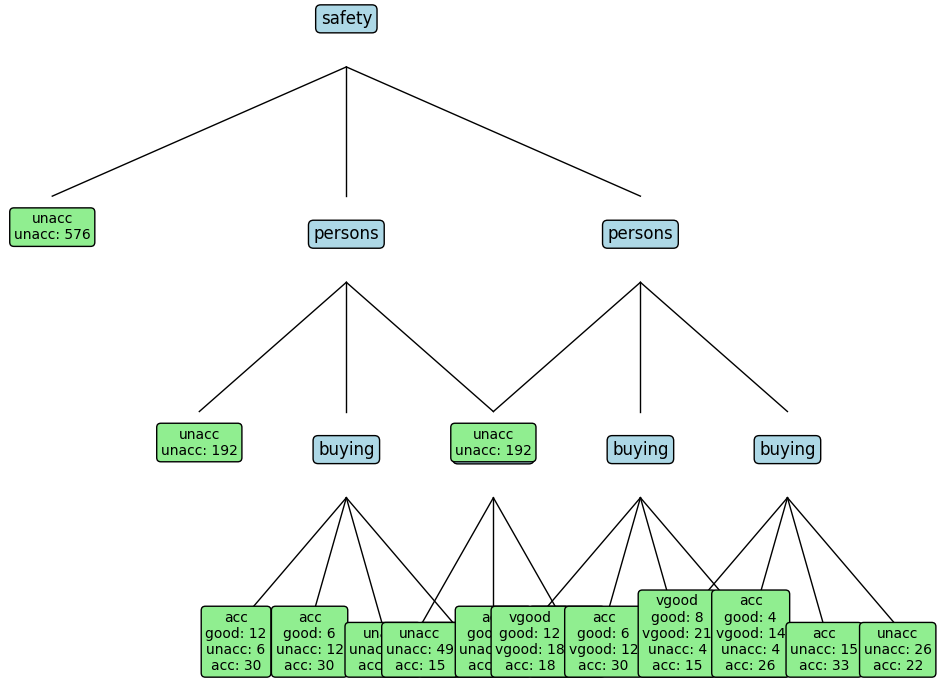

In [30]:

# Visualize the decision tree
def plot_tree(tree, depth=0, x_offset=0.5, y_offset=1.0, x_gap=0.25, ax=None, data=None, attribute_names=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.axis('off')  # Turn off the axes

    # If the tree is a leaf node, plot the label and counts
    if not isinstance(tree, dict):
        # Count the occurrences of each label in the current leaf data subset
        label_counts = {label: sum(1 for row in data if row[-1] == label) for label in set(row[-1] for row in data)}
        # Format the label text to include counts of each class
        label_text = f"{tree}\n" + "\n".join([f"{label}: {count}" for label, count in label_counts.items()])
        ax.text(x_offset, y_offset, label_text, fontsize=10, ha='center', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", edgecolor="black"))
        return

    # Get the current decision attribute name
    root = list(tree.keys())[0]
    attribute_name = attribute_names[root]  # Map the index to the attribute name
    ax.text(x_offset, y_offset, f"{attribute_name}", fontsize=12, ha='center',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", edgecolor="black"))

    # Recursively plot child nodes
    num_children = len(tree[root])
    for i, (value, subtree) in enumerate(tree[root].items()):
        child_x = x_offset + (i - (num_children - 1) / 2) * x_gap  # Calculate child x position
        child_y = y_offset - 0.1  # Shift vertically for the child nodes

        # Draw a line to the child node
        ax.plot([x_offset, child_x], [y_offset - 0.02, child_y + 0.02], 'k-', lw=1)

        # Recursively call plot_tree for the child node, passing the subset of data that corresponds to the child
        subset = split_data(data, root, value)  # Get the subset of data for this child
        plot_tree(subtree, depth + 1, child_x, child_y, x_gap / 2, ax=ax, data=subset, attribute_names=attribute_names)

    if depth == 0:  # Show the plot only at the top level
        plt.show()



# Visualize the decision tree
plt.figure(figsize=(14, 8))
plot_tree(tree, data=data, attribute_names=attribute_names)

In [35]:
# Test prediction
test_instance = {0: 1, 1: 2}  # Middle-aged with High income
prediction = predict(tree, test_instance)
print("\nPrediction for test instance:", "Yes" if prediction == 1 else "No")


Prediction for test instance: No
